Does Enhancing Images also Enhance the Outcome of Image Recognition of Neural Networks

# General Layout for this program

1. Imports
2. Load the image set
3. Format the image set to be used in resnet
4. Load in a pretrained resnet18 image set
5. Retrain resnet18 on the image set

Imports

In [35]:
import torch
import torchvision
from torchvision import models
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from PIL import Image

import cv2


**Testing that I can apply clahe to a sample jpeg

In [36]:
import matplotlib.image as mpimg

picture_height = 0
picture_width = 0


## Code to identify the largest photo
for dirname, _, filenames in os.walk("./images"):
    for filename in filenames:
        if (".JPEG" not in filename):
            continue
        temp_img = mpimg.imread(os.path.join(dirname, filename))
        (temp_height, temp_width, temp_size) = temp_img.shape

        if temp_height > picture_height:
            picture_height = temp_height
        if temp_width > picture_width:
            picture_width = temp_width


print(picture_height)
print(picture_width)


318
426


<class 'numpy.ndarray'>
(318, 426)


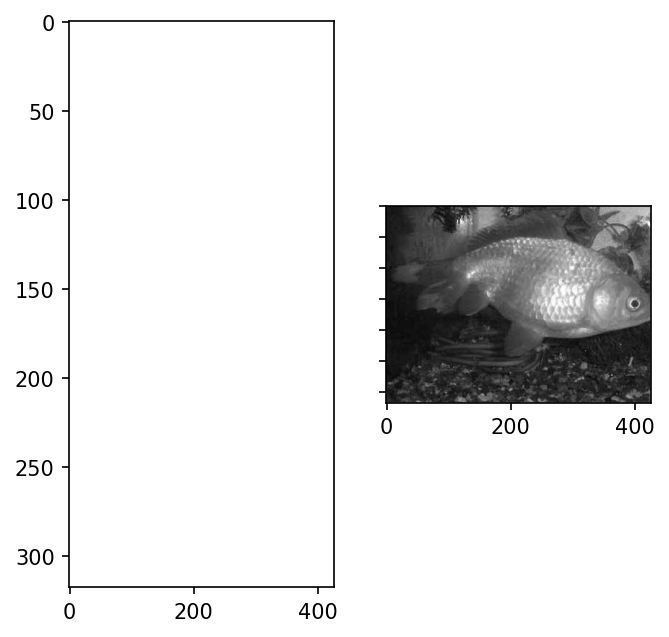

In [37]:


img_1_np = cv2.imread("./images/fish.JPEG", 0)
print(type(img_1_np))
print(img_1_np.shape)

img_1_np = np.pad(img_1_np, ((0, picture_height - img_1_np.shape[0]),(0, picture_width - img_1_np.shape[1])))

#new_img_1 = Image.fromarray(img_1_np)


clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(8,8))

#print(type(clahe))

clahe_img_1 = clahe.apply(img_1_np)

fig, ((new_ax1,  new_ax2)) = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True, figsize = (5, 5), dpi = 150, num = 1)
#new_ax1.imshow(clahe_img_1, cmap = "gray") # Images are gray scale, ensuring that matplotlib displays them as such
new_ax2.imshow(img_1_np, cmap = "gray")

**Back to our regularily scheduled program

In [38]:
#Set up a transform to noramilze all the images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Number of training examples
batch_size = 10

#Load the train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#Define the classes for each (Already know these hence hard coded labels)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [39]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(type(np.transpose(npimg, (1, 2, 0))))
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.show()


# get some random training images
dataiter = iter(trainloader)
print(type(dataiter))
images, labels = dataiter.next()
print(type(images))

# show images
imshow(torchvision.utils.make_grid(images))
# print images
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>


Process images with CLAHE (Contrast Limited Adaptive Histogram)

Turn all the images into numpy images

In [40]:
def getImgs(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

dataiter = iter(trainloader)
images, labels = dataiter.next()

#turn all the images into np arrays 
trainImages = getImgs(torchvision.utils.make_grid(images))


Get the size of the images

Apply CLAHE to the images

In [41]:
def applyClahe(clahe, imgSet):
    newSet = []
    for img in imgSet:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = clahe.apply(img) + 30
        newSet.append(img)

    return newSet

#Applying CLAHE to them (Going to leave it in colour for the first try)
clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize = (8,8))

img = trainImages[0]

#Turn the array into an image
#img = Image.fromarray(img)

print(type(img))

img = clahe.apply(img)

#trainImagesClahed = applyClahe(clahe, trainImages)

<class 'numpy.ndarray'>


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/clahe.cpp:353: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'


Load a pretrained resnet18 NN

In [ ]:
#Load in resnet 18
model = models.resnet18(pretrained=True)

#Freeze the weights of the model
for param in model.parameters():
    param.requires_grad = False


NameError: name 'models' is not defined

Load in the image set

In [ ]:
#Applying CLAHE to each image set
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

#for image in trainImages:
#    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#    finalImage = clahe.apply(image_bw) + 30
#    cv2.imshow("Image", finalImage)
#    break
#for image in trainImages:

img_1 = Image.open("./fish.JPEG")

#picture_height = 3567 # Manually set
#picture_width = 3827 # Manually set
picture_width, picture_height = img_1.size
np_img_1 = np.array(img_1)

print(picture_height - np_img_1.shape[0])
print(picture_width - np_img_1.shape[1])
print(picture_height)
print(picture_width)
print(np_img_1.shape)

#img_1_np = np.pad(np_img_1, ((0, picture_height - np_img_1.shape[0]),(0, picture_width - np_img_1.shape[1])))
img_1_np = cv2.cvtColor(np_img_1, cv2.COLOR_BGR2GRAY)
clahe_img = clahe.apply(np_img_1)



0
0
318
426
(318, 426, 3)


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/clahe.cpp:353: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'


Train model A on CLAHE data set, and model B on regular image set

Graph the differences in the model accuracy